# Bootstrap sampling

In [10]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import *  # imports all functions from definitions.py

xr.set_options(
    keep_attrs=True, display_style="html"
)  # Attributes of DataArrays will be kept through operations.

alt = [
    70,
    72,
    74,
    76,
    78,
    80,
    82,
    84,
    86,
    88,
    90,
    92,
    94,
    96,
    98,
    100,
    102,
    104,
    106,
    108,
    110,
    112,
    114,
    116,
    118,
    120,
]
root_path = "/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/"
dir_path = "/home/hochatmstud/bene/"

In [27]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.

    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    # print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [12]:
station = "Leipzig"

## Wind measurements

In [13]:
ds_wind = read_group("wind", station)

u = read_var(ds_wind, "u0")
v = read_var(ds_wind, "v0")

u_anomalie = anomalie("dayofyear", u)

v_anomalie = anomalie("dayofyear", v)

sea_u = sea(40, station, u)
sea_u_anomalie = sea(40, station, u_anomalie)

sea_v = sea(40, station, v)
sea_v_anomalie = sea(40, station, v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [110]:
# if station == 'RioGrande':
doy = u.time.dt.dayofyear
year_arr = u.time.dt.year
mask_2009 = (
    ((year_arr == 2009) & (doy <= 31))
    | ((year_arr == 2011) & (doy >= 45) & (doy <= 54))
    | ((year_arr == 2008) & (((doy >= 325) & (doy <= 340)) | (doy >= 355)))
)

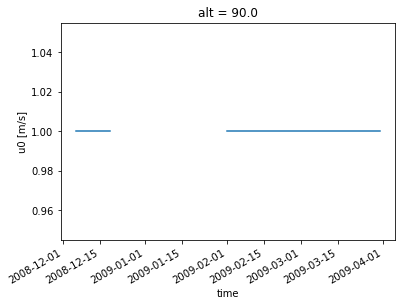

In [111]:
xr.ones_like(u).where(~mask_2009).sel(alt=90, time=slice("2008-12", "2009-03")).plot()

In [112]:
mask_2009

<xarray.DataArray (time: 5997)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2004-08-01 2004-08-02 ... 2020-12-31

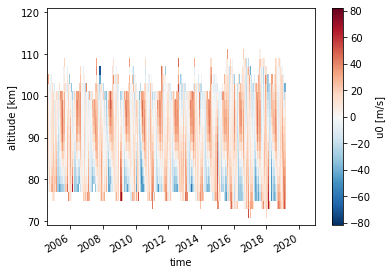

In [113]:
u.where(~mask_2009).plot(x="time")

In [14]:
# var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2]  # 20 or 30 ; input timescale
its = 10000  # 10000 ; number of samples
# what = sys.argv[4] # anomalies ; what kind of anomalies
# DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True  # allows rechunking in xr.apply_ufunc

if station == "Leipzig":
    size = 7
elif station == "Esrange":
    size = 11
elif station == "Sodankyla":
    size = 4
elif station == "Sodankyla_Kiruna":
    size = 11
elif station == "CMOR":
    size = 9
elif station == "RioGrande":
    size = 3
elif station == "Davis":
    size = 7

line_width = 5

In [15]:
# u_anomalie
u_anomalie.name = "statistical significance"

### for-loop via the lags

In [16]:
u_anomalie = u_anomalie.sel(alt=slice(80, 100)).dropna("time")

In [17]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80, 100)).dropna("days")

In [25]:
sea_u_anomalie["u0_mean"]

<xarray.DataArray 'u0_mean' (days: 81, alt: 11)>
array([[-4.72004762e+00, -4.22671429e+00, -3.76857143e+00,
        -3.35023810e+00, -2.74761905e+00, -1.90257143e+00,
        -2.39790476e+00, -2.35904762e+00, -2.54990476e+00,
        -2.73538095e+00, -2.91885714e+00],
       [-5.45280952e+00, -5.72033333e+00, -4.91742857e+00,
        -4.45109524e+00, -4.19009524e+00, -4.50595238e+00,
        -4.15185714e+00, -4.18100000e+00, -4.12766667e+00,
        -4.45595238e+00, -4.06685714e+00],
       [-2.44104762e+00, -3.15195238e+00, -3.54076190e+00,
        -4.46009524e+00, -5.17871429e+00, -5.31661905e+00,
        -4.78900000e+00, -3.66995238e+00, -2.88500000e+00,
        -2.40700000e+00, -8.97190476e-01],
       [-1.78780952e+00, -2.68609524e+00, -3.53276190e+00,
        -4.17657143e+00, -4.61266667e+00, -4.65857143e+00,
        -3.67685714e+00, -2.17200000e+00, -9.35238095e-02,
         1.80185714e+00,  1.36485714e+00],
       [-2.87171429e+00, -2.46671429e+00, -1.84100000e+00,
        -1.45814286e+00, -9.69333333e-01, -5.19857143e-01,
         1.45238095e-02,  9.25761905e-01,  2.61338095e+00,
         4.13571429e+00,  5.28833333e+00],
       [-3.18919048e+00, -1.99076190e+00, -1.28404762e+00,
        -3.06857143e-01,  3.66619048e-01,  1.28795238e+00,
         2.07147619e+00,  2.84819048e+00,  3.87923810e+00,
         5.38000000e+00,  7.81395578e+00],
       [-5.73857143e+00, -4.99823810e+00, -3.77942857e+00,
        -2.87333333e+00, -2.00714286e+00, -1.25219048e+00,
        -6.39619048e-01,  2.19380952e-01,  1.62214286e+00,
         3.52790476e+00,  9.86304422e+00],
       [-5.13161905e+00, -5.12461905e+00, -4.36700000e+00,
        -3.36328571e+00, -2.32461905e+00, -1.93200000e+00,
        -1.76100000e+00, -1.08471429e+00,  4.70952381e-02,
         1.39171429e+00,  5.68355442e+00],
       [-6.09509524e+00, -5.81176190e+00, -5.57514286e+00,
        -5.40723810e+00, -4.49780952e+00, -3.61371429e+00,
        -2.41814286e+00, -1.20580952e+00,  4.39047619e-01,
         1.57400000e+00,  1.73105952e+00],
       [-5.79695238e+00, -6.08109524e+00, -5.45090476e+00,
        -4.91980952e+00, -3.89771429e+00, -3.22128571e+00,
        -2.49661905e+00, -1.57628571e+00, -1.73095238e-01,
         1.51466667e+00,  7.75892857e-01],
       [-3.89009524e+00, -3.65009524e+00, -3.02485714e+00,
        -1.63880952e+00,  2.43571429e-01,  2.38223810e+00,
         4.54257143e+00,  6.43252381e+00,  7.78100000e+00,
         8.52090476e+00,  6.52846939e+00],
       [-9.63761905e-01, -1.29738095e+00, -7.28761905e-01,
         8.86380952e-01,  3.23633333e+00,  5.55180952e+00,
         7.49695238e+00,  8.63719048e+00,  8.32700000e+00,
         6.09338095e+00,  3.43150340e+00],
       [-1.83838095e+00, -2.12733333e+00, -1.44590476e+00,
         2.44761905e-01,  2.58585714e+00,  4.70209524e+00,
         5.62866667e+00,  5.35142857e+00,  4.48342857e+00,
         2.90900000e+00, -7.30122449e-01],
       [-2.99347619e+00, -2.73176190e+00, -1.98238095e+00,
        -9.13809524e-01,  9.65095238e-01,  2.04457143e+00,
         1.87319048e+00,  1.41390476e+00,  1.85809524e-01,
        -1.33500000e+00, -1.63452041e+00],
       [-4.69171429e+00, -4.82804762e+00, -5.25404762e+00,
        -4.93790476e+00, -4.11495238e+00, -3.56647619e+00,
        -3.03600000e+00, -2.53690476e+00, -1.97523810e+00,
        -1.81709524e+00, -3.91761905e-01],
       [-4.29385714e+00, -4.83166667e+00, -5.12485714e+00,
        -4.75228571e+00, -5.38466667e+00, -5.85814286e+00,
        -5.87000000e+00, -5.26047619e+00, -3.80714286e+00,
        -1.70271429e+00, -9.31275510e-01],
       [-6.26915476e+00, -6.40870238e+00, -6.05804762e+00,
        -5.57304762e+00, -4.79389286e+00, -4.27653571e+00,
        -4.21771429e+00, -3.73022619e+00, -3.39096429e+00,
        -1.72396429e+00, -8.21765306e-01],
       [-6.56114286e+00, -7.05138095e+00, -7.03071429e+00,
        -6.06719048e+00, -4.47657143e+00, -2.78285714e+00,
        -1.94642857e+00, -9.72904762e-01, -5.51285714e-01,
        -9.03714286e-01, -2.746099

In [24]:
u_anomalie

<xarray.DataArray 'statistical significance' (time: 4597, alt: 11)>
array([[ 3.77033333,  4.82166667,  5.325     , ...,  2.913     ,
         0.95366667, -3.26321429],
       [ 8.58566667,  7.795     ,  6.37066667, ...,  1.91966667,
         0.213     , -4.313     ],
       [ 8.90366667, 11.38333333, 11.41433333, ...,  4.511     ,
         0.64      , -3.29733333],
       ...,
       [ 2.29833333,  1.68866667,  0.80866667, ..., -1.719     ,
        -1.284     , -0.36      ],
       [ 8.873     ,  8.302     ,  7.41066667, ..., 11.08566667,
        12.826     , -6.62125   ],
       [13.844     , 14.352     , 14.286     , ..., 13.86333333,
        16.09933333, 16.14318182]])
Coordinates:
  * alt        (alt) float64 80.0 82.0 84.0 86.0 88.0 ... 94.0 96.0 98.0 100.0
  * time       (time) datetime64[ns] 2004-08-01 2004-08-02 ... 2019-03-06
    dayofyear  (time) int64 214 215 216 217 218 219 220 ... 59 60 61 62 63 64 65
Attributes:
    zonal wind:  zonal / m/s
    units:       m/s

In [28]:
p = []

for lag in range(-40, 41, 1):
    # print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(
        u_anomalie, its, "time", replace=True, chunk=False, dim_max=size
    )
    # print(rnd_arr)
    print("".ljust(line_width) + "{} samples generated".format(its))
    ## load of composite dataarray
    # comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    # ds_comp = xr.open_dataarray(comp_file)*factor
    # print("".ljust(line_width)+'{} opened'.format(comp_file))

    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(
        g_kde,
        rnd_arr,
        sea_u_anomalie["u0_mean"].sel(days=lag),
        input_core_dims=[["iteration"], []],
        vectorize=True,
        dask="parallelized",
        exclude_dims=set(("iteration",)),
        output_core_dims=[[]],
        output_dtypes=[sea_u_anomalie["u0_mean"].dtype],
    )
    print("".ljust(line_width) + "p-values calculated")
    # output the calculation
    # outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde.name = u_anomalie.name
    # da_kde.to_netcdf(outfile_name)
    # print("".ljust(line_width)+'{} saved'.format(outfile_name))
    # del da_kde, rnd_arr, ds_comp
    # print()
    # da_kde.plot.scatter(y='alt', x='u0_mean')
    # da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde)

     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated
     p-values calculated
     10000 samples generated

(array([1.000e+00, 1.000e+01, 1.060e+02, 8.000e+02, 2.229e+03, 3.448e+03,
        2.412e+03, 8.310e+02, 1.510e+02, 1.200e+01]),
 array([-15.59737755, -12.7836449 ,  -9.96991224,  -7.15617959,
         -4.34244694,  -1.52871429,   1.28501837,   4.09875102,
          6.91248367,   9.72621633,  12.53994898]),
 <a list of 10 Patch objects>)

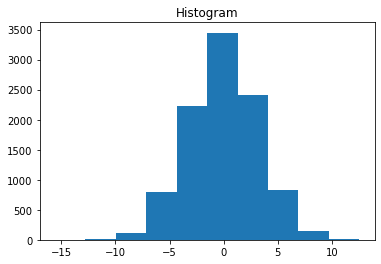

In [31]:
rnd_arr.sel(alt=90).plot.hist()

In [1]:
y = rnd_arr.sel(alt=90)
mask = np.isnan(y)
y[~mask]

NameError: name 'rnd_arr' is not defined

In [52]:
rnd_arr.sel(alt=90).median()

<xarray.DataArray ()>
array(-0.00955272)
Coordinates:
    alt      float64 90.0

In [35]:
sea_u_anomalie["u0_mean"].sel(days=lag, alt=90)

<xarray.DataArray 'u0_mean' ()>
array(-1.24909864)
Coordinates:
    alt      float64 90.0
    days     int64 40
Attributes:
    zonal wind:  zonal / m/s
    units:       m/s

In [36]:
p_comp = xr.concat(p, dim="days")
p_comp["days"] = range(-40, 40 + 1)
# p_comp = p_comp.where(p_comp['u0_mean'] < 0.05, other = -0.05)

In [39]:
p_comp

<xarray.DataArray 'statistical significance' (days: 81, alt: 11)>
array([[4.67349659e-02, 5.21886995e-02, 5.97998809e-02, 6.89922356e-02,
        8.34417846e-02, 1.04595287e-01, 9.24765008e-02, 9.22197304e-02,
        9.02321727e-02, 9.05450275e-02, 7.85783943e-02],
       [3.33061907e-02, 2.83943553e-02, 3.73242005e-02, 4.85779595e-02,
        5.22604603e-02, 4.57600632e-02, 5.57216654e-02, 5.68507606e-02,
        6.20789784e-02, 5.70231800e-02, 5.89898518e-02],
       [8.69306407e-02, 7.28706553e-02, 6.35009447e-02, 4.52828099e-02,
        3.22012788e-02, 3.17847578e-02, 4.04332849e-02, 6.46917192e-02,
        8.57501296e-02, 9.48469403e-02, 9.60489134e-02],
       [9.43741313e-02, 8.26802036e-02, 6.34649357e-02, 4.84496837e-02,
        4.16248044e-02, 4.12783152e-02, 6.53202368e-02, 1.01859655e-01,
        1.21670718e-01, 9.56058866e-02, 9.54820683e-02],
       [7.74201122e-02, 8.95825121e-02, 1.02835133e-01, 1.10885380e-01,
        1.15787435e-01, 1.22333505e-01, 1.23907216e-01, 1.15165347e-01,
        8.16639606e-02, 4.70278421e-02, 4.15772427e-02],
       [7.18158111e-02, 9.73323063e-02, 1.15195428e-01, 1.24458822e-01,
        1.25988966e-01, 1.17250809e-01, 9.70415757e-02, 8.06183855e-02,
        5.47188321e-02, 2.95624547e-02, 1.38204997e-02],
       [2.70525614e-02, 3.56090370e-02, 5.59191660e-02, 7.56275078e-02,
        9.87984494e-02, 1.14737284e-01, 1.20100727e-01, 1.19266811e-01,
        1.02341816e-01, 6.32270146e-02, 4.56343300e-03],
       [4.11651678e-02, 3.68441109e-02, 5.04818527e-02, 7.02067767e-02,
        9.10987012e-02, 1.00868340e-01, 1.05679013e-01, 1.15017760e-01,
        1.22601374e-01, 1.00738928e-01, 3.56920908e-02],
       [2.69327804e-02, 2.73058068e-02, 2.72301366e-02, 2.86483930e-02,
        4.29983848e-02, 6.58658700e-02, 9.59844756e-02, 1.13465184e-01,
        1.20491855e-01, 1.00598358e-01, 9.27944919e-02],
       [2.89105665e-02, 2.22927687e-02, 2.86227782e-02, 3.32006341e-02,
        5.78545065e-02, 7.40711796e-02, 9.18791643e-02, 1.12773756e-01,
        1.20424868e-01, 1.02491431e-01, 1.03102254e-01],
       [5.77240553e-02, 6.36641593e-02, 7.60259776e-02, 1.10351679e-01,
        1.24453648e-01, 9.24181897e-02, 4.22411716e-02, 1.58432577e-02,
        6.67263815e-03, 5.15108174e-03, 2.42785801e-02],
       [1.00450859e-01, 1.04497026e-01, 1.15155553e-01, 1.19629541e-01,
        7.46157793e-02, 2.78194040e-02, 8.81874611e-03, 3.90714801e-03,
        4.66473262e-03, 1.91353302e-02, 6.77058573e-02],
       [9.80737933e-02, 9.57004429e-02, 1.07569686e-01, 1.25353893e-01,
        9.00425736e-02, 4.12416897e-02, 2.38892197e-02, 2.82714183e-02,
        4.10314192e-02, 7.20267058e-02, 1.04953543e-01],
       [7.47184727e-02, 8.01892763e-02, 1.02991366e-01, 1.19551429e-01,
        1.17397460e-01, 9.80991788e-02, 1.03228226e-01, 1.06749930e-01,
        1.19976315e-01, 1.03523902e-01, 9.39287771e-02],
       [4.38992356e-02, 4.09566814e-02, 3.30695852e-02, 3.65464609e-02,
        5.51787330e-02, 6.75905226e-02, 8.10899637e-02, 9.53448591e-02,
        1.06304475e-01, 1.05206999e-01, 1.04201689e-01],
       [4.89556756e-02, 3.78790637e-02, 3.32648964e-02, 3.88002941e-02,
        2.84699546e-02, 2.40328250e-02, 2.47660421e-02, 3.42264133e-02,
        6.23570643e-02, 1.08097507e-01, 9.90335755e-02],
       [2.69338165e-02, 2.17463908e-02, 2.28999891e-02, 2.79761141e-02,
        4.02724473e-02, 5.17393225e-02, 5.48529670e-02, 6.69595421e-02,
        7.48096920e-02, 1.05561554e-01, 9.88400426e-02],
       [2.23162660e-02, 1.47086316e-02, 1.28120835e-02, 2.03401466e-02,
        4.71867428e-02, 9.01621748e-02, 1.08311224e-01, 1.19239238e-01,
        1.19805107e-01, 1.12109338e-01, 8.09761766e-02],
       [2.55093158e-02, 2.10802400e-02, 2.81217788e-02, 5.44192917e-02,
        8.52540990e-02, 1.04548072e-01, 1.03106276e-01, 9.98323895e-02,
        1.08325664e-01, 1.12671511e-01, 9.95587080e-02],
       [2.40404228e-02, 2.61075837e-02, 3.38304697e-02, 5.25085713e-02,
        8.04476546e-02, 1.13882879e-01, 1.2

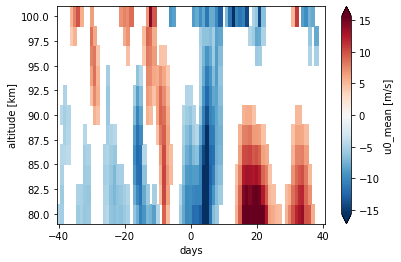

In [50]:
sea_u_anomalie["u0_mean"].where(p_comp < 0.05).plot(x="days", robust=True)

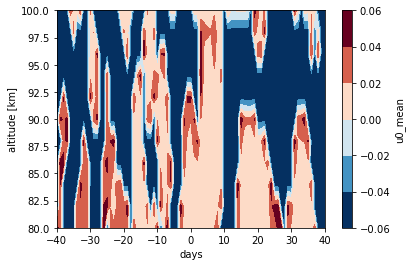

In [21]:
p_comp["u0_mean"].plot.contourf(x="days")